# **INTRODUCTION**

---
This notebook is one of the submissions done for Business Analytics Capstone.


We import the necessary libraries for this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import textwrap
import calendar

The datasets that we are going to use were downloaded from the Toronto government's open data portal at https://open.toronto.ca/dataset/ttc-subway-delay-data/

At the time of this project, the portal was last updated on October 18, 2024.

The files were imported into python as excel files. The excel files containing data for periods June 2017 to 2021 have individual sheets containing the monthly data. We'll concatenate these into one annual data frame.

In [2]:
df_2024 = pd.read_excel('/content/ttc-subway-delay-data-2024.xlsx', sheet_name = None)
df_2023 = pd.read_excel('/content/ttc-subway-delay-data-2023.xlsx', sheet_name = None)
df_2022 = pd.read_excel('/content/ttc-subway-delay-data-2022.xlsx', sheet_name = None)
df_2021 = pd.read_excel('/content/ttc-subway-delay-data-2021.xlsx', sheet_name = None)
df_2020 = pd.read_excel('/content/ttc-subway-delay-data-2020.xlsx', sheet_name = None)
df_2019 = pd.read_excel('/content/ttc-subway-delay-data-2019.xlsx', sheet_name = None)
df_2018 = pd.read_excel('/content/ttc-subway-delay-data-2018.xlsx', sheet_name = None)
df_jan2014apr2017 = pd.read_excel('/content/ttc-subway-delay-jan-2014-april-2017.xlsx', sheet_name = None)
df_may2017dec2017 = pd.read_excel('/content/ttc-subway-delay-may-december-2017.xlsx', sheet_name = None)

df_2024 = pd.concat(df_2024.values(), ignore_index = True)
df_2023 = pd.concat(df_2023.values(), ignore_index = True)
df_2022 = pd.concat(df_2022.values(), ignore_index = True)
df_2021 = pd.concat(df_2021.values(), ignore_index = True)
df_2020 = pd.concat(df_2020.values(), ignore_index = True)
df_2019 = pd.concat(df_2019.values(), ignore_index = True)
df_2018 = pd.concat(df_2018.values(), ignore_index = True)
df_jan2014apr2017 = pd.concat(df_jan2014apr2017.values(), ignore_index = True)
df_may2017dec2017 = pd.concat(df_may2017dec2017.values(), ignore_index = True)
df_codes = pd.read_excel('/content/ttc-subway-delay-codes.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: '/content/ttc-subway-delay-data-2024.xlsx'

We combine the annual datasets into one dataframe, in preparation for data cleaning. For now, we're not including the data frame on the delay codes.

In [ ]:
df_master = pd.concat([df_2024, df_2023, df_2022, df_2021, df_2020, df_2019, df_2018, df_may2017dec2017, df_jan2014apr2017], ignore_index = True)

Let's look into the consolidated data set by describing it to see just what we're working with.

In [ ]:
df_master

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2024-01-01,02:00,Monday,SHEPPARD STATION,MUI,0,0,N,YU,5491
1,2024-01-01,02:00,Monday,DUNDAS STATION,MUIS,0,0,N,YU,0
2,2024-01-01,02:08,Monday,DUNDAS STATION,MUPAA,4,10,N,YU,6051
3,2024-01-01,02:13,Monday,KENNEDY BD STATION,PUTDN,10,16,E,BD,5284
4,2024-01-01,02:22,Monday,BLOOR STATION,MUPAA,4,10,N,YU,5986
...,...,...,...,...,...,...,...,...,...,...
215597,2017-04-30,19:50,Sunday,BLOOR DANFORTH SUBWAY,MUO,0,0,NaN,BD,0
215598,2017-04-30,20:25,Sunday,WARDEN STATION,SUDP,4,8,W,BD,5107
215599,2017-04-30,20:29,Sunday,KEELE STATION,SUROB,0,0,NaN,BD,0
215600,2017-04-30,22:00,Sunday,YONGE UNIVERSITY LINE,MUO,0,0,NaN,YU/BD,0


We'll be working with 215,602 rows of data recorded from January 2014 to September 30, 2024. We have ten (10) attributes:

1) Date - in YYYY/MM/DD;

2) Time - in 24H clock;

3) Day - name of the day of the week;

4) Station - TTC subway station name;

5) Code - TTC delay code;

6) Min Delay - delay (in minutes) to subway service;

7) Min Gap - time length (in minutes) between trains;

8) Bound - direction of the train dependend on the line;

9) Line - TTC subway line, i.e. YU, BD, SHP, and SRT; and

10) Vehicle - TTC train number.

# **DATA CLEANING**

---

Here we remove duplicates, leading and trailing spaces, and try to fill null values or remove them if otherwise.


## Duplicates

In [ ]:
df_master.duplicated().sum()

194

In [ ]:
df_master.drop_duplicates(inplace = True)
df_master.shape

(215408, 10)

## Leading and Trailing Spaces

Let's drop leading and trailing spaces in our data.

In [ ]:
for col in df_master.select_dtypes(include = ['object']):
  df_master[col] = df_master[col].str.strip()

## Null Values

Let's check for any null values.

In [ ]:
df_master.isnull().sum()

,0
Date,0
Time,0
Day,0
Station,0
Code,1
Min Delay,0
Min Gap,0
Bound,55483
Line,683
Vehicle,0


### 'Code' Column

The 'Code' column has one (1).

In [ ]:
print(df_master[df_master['Code'].isnull()])

             Date   Time     Day          Station Code  Min Delay  Min Gap  \
137145 2017-07-07  06:09  Friday  COXWELL STATION  NaN          0        0   

       Bound Line  Vehicle  
137145     E   BD     5124  


It's a delay occurrence in Coxwell Station that lasted less than a minute. To remedy this, we drop the row with the null value.

In [ ]:
df_master = df_master.dropna(subset=['Code'])

### 'Bound' Column

The 'Bound' column has 55,588 null entries.

The 'Bound' column records the direction the train was heading to when the delay occurred. Looking into a snapshot of the dataframe with the null entries in the 'Bound' column, we can see that we still have the other data in the other columns such as Date, Time, Station, and Min Gap. These are more important compared to the data on the direction of the train, at least relative to the purpose of this project.

As such, we will not be removing the rows with null entries in the 'Bound' column.

### 'Line' Column


The 'Line' column has 683 null entries.

The 'Line' column contains data on which TTC line the delay occurred. As of writing, there are/were officially four (4) TTC subway lines: Line 1 Yonge-University, Line 2 Bloor-Danforth, Line 3 Scarborough, and Line 4 Sheppard. Line 3 Scarborough was closed in July 2023.

In [ ]:
print(df_master[df_master['Line'].isnull()])

             Date   Time        Day                Station   Code  Min Delay  \
2257   2024-01-31  01:41  Wednesday        SPADINA STATION   MUIS          0   
2498   2024-02-04  00:08     Sunday    SPADINA YUS STATION   MUIS          0   
3413   2024-02-16  22:01     Friday          GUNN BUILDING   PUMO          0   
3687   2024-02-20  22:13    Tuesday          QUEEN STATION    SUO          0   
7095   2024-04-07  01:11     Sunday       UNKNOWN LOCATION    MUO          0   
...           ...    ...        ...                    ...    ...        ...   
213229 2017-03-14  14:14    Tuesday          GUNN BUILDING   MUIE          0   
213456 2017-03-18  15:58   Saturday     KENNEDY BD STATION  MUIRS          0   
213511 2017-03-20  00:21     Monday           JANE STATION  PUMEL          0   
214820 2017-04-15  05:35   Saturday          QUEEN STATION  MUNCA          0   
214894 2017-04-16  16:01     Sunday  ST GEORGE YUS STATION   MUIS          0   

        Min Gap Bound Line  Vehicle  
2

Upon checking the rows above with null entries in the 'Line' column, we can see that we can interpolate from the 'Station' column the TTC line in which the delay occurred.

Our data cleaning won't be as straightforward as it seems...

Let's look at the 'Station' column more closely.

### 'Station' Column

There are 1,279 unique data entries under the 'Station' column. This poses a huge challenge in our data cleaning efforts. Certain stations appear in different forms, for instance: 'Vaughan MC to Finch St', 'Vaughan MC Station', Vaughan MC Station to', etc.

In [ ]:
print(len(df_master['Station'].unique()))

1279


Here we run in a notable issue within the TTC Delay Dataset: it's not very precise.
For instance, 'Vaughan MC to Finch St' may mean the delay occurred somewhere between Vaughan Metropolitan Centre Station to Finch Station. If we check the TTC subway map, however, we can see that there are 32 stations between the former and the latter. So how do we know for certain in which station this delay occurred?

To simplify things, we'll assume that the first station name that appeared in the 'Station' column is the station in which the delay occurred, regardless whether the actual delay happened in between stations, i.e. while the train is running between stations.


In [ ]:
df_master_unique = df_master['Station'].unique()
df_master_unique

array(['SHEPPARD STATION', 'DUNDAS STATION', 'KENNEDY BD STATION', ...,
       'MOORE GATE', 'PLANT OPS BLDG', 'BLOOR YONGE LINES'], dtype=object)

In [ ]:
df_master_unique = pd.DataFrame(df_master_unique, columns = ['Station'])
df_master_unique

,Station
0,SHEPPARD STATION
1,DUNDAS STATION
2,KENNEDY BD STATION
3,BLOOR STATION
4,ST CLAIR STATION
...,...
1274,CLANTON PARK EMERGENCY
1275,PRINCE EDWARD VIADUCT
1276,MOORE GATE
1277,PLANT OPS BLDG


We'll do our data cleaning step-by-step.

First, we'll create a dictionary of all the stations as keys and their related values. We need to refine the values to make sure that we're capturing all the unique names, even the ones with typographical errors. At the same time, we should ensure that we're not assigning a station to the wrong one. For instance, in the above example, 'Vaughan MC to Finch St' should be tagged to Vaughan Metropolitan Center Station and not to Finch Station.

In [ ]:
line_1 = {
    'Vaughan Metropolitan Centre' : ['vau', 'vmc', '3150 Hwy 7'],
    'Highway' : ['highway', 'high way', '7332 Jane St'],
    'Pioneer Village' : ['pio', 'pioneer_village', '185 Northwest Gt'],
    'York University' : ['york uni', 'york_university', '120 Ian Macdonald Blvd'],
    'Finch West' : ['finch west', 'finch_west', '3950 Keele St'],
    'Downsview Park' : ['downsview', 'down', 'downsview_park', '25 Vitti St'],
    'Sheppard West' : ['sheppard west', 'sheppard_west', '1035 Sheppard Ave W'],
    'Wilson' : ['wils', 'wisl', '570 Wilson Ave'],
    'Yorkdale' : ['yorkdale', '50 Yorkdale Rd'],
    'Lawrence West' : ['lawrence west', 'lawrence_west', '665 Lawrence Ave W'],
    'Glencairn' : ['glen', '785 Glencairn Ave'],
    'Eglinton West' : ['eglinton west', 'eglinton_west', '1300 Eglinton Ave W'],
    'St. Clair West' : ['st clair west', 'st. clair west', 'st_clair_west', '370 St Clair Ave W'],
    'Dupont' : ['dupont', '263 Dupont St'],
    'Museum' : ['museum', '75 Queen\'s Park'],
    'Queens Park' : ['queens park', 'queens_park', '671 University Ave'],
    'St. Patrick' : ['st patr', 'st. patr', 'stpatr', 'st_patrick', '449 University Ave'],
    'Osgoode' : ['osgoode', '181 Queen St W'],
    'St. Andrew' : ['st and', 'st. and', 'standr', 'st_andrew', '173 King St W'],
    'Union' : ['union', '55 Front St W'],
    'King' : ['king', '3 King St E'],
    'Queen' : ['queen', '3 Queen St E'],
    'Dundas' : ['dund', '3 Dundas St E'],
    'College' : ['college', '3 Carlton St'],
    'Wellesley' : ['welles', 'welle', 'wells', '16 Wellesley St E'],
    'Rosedale' : ['rosedale', '7 Crescent Rd'],
    'Summerhill' : ['summe', '16 Shaftesbury Ave'],
    'St. Clair' : ['st clair', 'st. cla', 'stcla', 'st.cla', 'st cal', 'st_clair', '15 St Clair Ave E'],
    'Davisville' : ['davis', '1900 Yonge St'],
    'Eglinton' : ['eglinton', 'egi', '2190 Yonge St'],
    'Lawrence' : ['lawr', 'lawer', '3101 Yonge St'],
    'York Mills' : ['york mills', 'york_mills', '4025 Yonge St'],
    'North York Centre' : ['north york', 'north_york_centre', '5152 Yonge St'],
    'Finch' : ['finch', 'ficn', '5714 Yonge St']}

line_2 = {
    'Kipling' : ['kipl', 'kilp', '950 Kipling Ave'],
    'Islington' : ['isli', '1240 Islington Ave'],
    'Royal York' : ['royal york', 'royal_york', '955 Royal York Rd'],
    'Old Mill' : ['old mill', 'old_mill', '2672 Bloor St W'],
    'Jane' : ['jane', '15 Jane St'],
    'Runnymede' : ['runnymede', '265 Runnymede Rd'],
    'High Park' : ['high park', 'high_park', '35 Quebec Ave'],
    'Keele' : ['keele', '21 Keele St'],
    'Dundas West' : ['dundas west', 'dunda we', 'dundas_west', '2365 Dundas St W'],
    'Lansdowne' : ['lansdowne', '691 Lansdowne Ave'],
    'Dufferin' : ['dufferin', '1006 Dufferin St'],
    'Ossington' : ['ossing', 'ossig', '746 Ossington Ave'],
    'Christie' : ['christie', '5 Christie St'],
    'Bathurst' : ['bathu', '819 Bathurst St'],
    'Bay' : ['bay', '1234 Bay St'],
    'Sherbourne' : ['sherbourne', '633 Sherbourne St'],
    'Castle Frank' : ['castle frank', 'castle_frank', '600 Bloor St E'],
    'Broadview' : ['broadview', 'braod', 'broad', 'brod', '769 Broadview Ave'],
    'Chester' : ['chester', '22 Chester Ave'],
    'Pape' : ['pape', '743 Pape Ave'],
    'Donlands' : ['donlands', '30 Donlands Ave'],
    'Greenwood' : ['greenwood', '10 Linnsmore Cres'],
    'Coxwell' : ['coxwell', 'cox', '355 Strathmore Blvd'],
    'Woodbine' : ['woodbine', '991 Woodbine Ave'],
    'Main Street' : ['main street', 'main_street', '315 Main St'],
    'Victoria Park' : ['victoria park', 'victoria_park', '777 Victoria Park Ave'],
    'Warden' : ['warden', '701 Warden Ave']}

line_3 = {
    'Lawrence East:' : ['lawrence east', 'lawrence_east', '2444 Lawrence Ave E'],
    'Ellesmere' : ['ellesmere', '1025 Ellesmere Rd'],
    'Midland' : ['midland', '2085 Midland Ave'],
    'Scarborough Centre' : ['scarb', 'scarborough_centre', '290 Borough Dr'],
    'Mccowan' : ['mcco', 'mc co', '1275 McCowan Rd']}

line_4 = {
    'Bayview' : ['bayview', '550 Sheppard Ave E'],
    'Bessarion' : ['bess', '731 Sheppard Ave E'],
    'Leslie' : ['leslie', '1209 Sheppard Ave E'],
    'Don Mills' : ['don m', 'donmi', 'don_mills', '1700 Sheppard Ave E']}

line_1_4 = {
    'Sheppard-Yonge' : ['sheppard', 'sheppard yonge', 'yonge shep', 'sehp', 'yonge shp', 'sheppard-yonge', '20 Sheppard Ave W']}

line_1_2 = {
    'Spadina' : ['spadina', '6 Spadina Rd'],
    'St. George' : ['st geo', 'stgeo', 'st. geo', 'st.geo', 'st_george', '139 St George St'],
    'Bloor-Yonge' : ['bloor', 'bloor-yonge', 'yonge', 'young', 'yu', 'danf', '35 Bloor St E',
                     'yonge bd', 'yonge-uni', 'yonge - uni', 'yonge / uni',
                     'yonge- uni', 'yonge uni', 'yonge/uni', 'yonge/u', 'yonge station',
                     'line 1 - yonge', 'line 1: yonge', 'subway line 1', 'yonge u']}

line_2_3 = {
    'Kennedy' : ['kenn', '2455 Eglinton Ave E']}

We'll need to run all the unique names in the 'station' column through our dictionary above. If any of the keywords match with the station name, the function below will return the "cleaned" station name in a newly created 'station_clean' column within the df_master dataframe.

In [ ]:
def clean_station_column(station):
    all_lines = {**line_1, **line_2, **line_3, **line_4, **line_1_2, **line_1_4, **line_2_3}
    for correct_station, values in all_lines.items():
      if any(value in station.lower() for value in values):
        return correct_station
    return "Other"

df_master['station_clean'] = df_master['Station'].apply(clean_station_column)

Second, from checking the unique values in 'Station', we can see that some data are correct in terms of spelling. There's only slight differences like punctuation (some have a period), abbreviated (e.g. VMC, VAUGHAN MC), or dialect (e.g. centre instead of center). We'll assign these to the new column 'station_clean'.

Though we already run these through our dictionary, we'll run it again through this "hard" assignment to make sure we're assigning the stations correctly.

In [ ]:
# force correct stations Line 1
df_master.loc[df_master['Station'] == 'VAUGHAN MC STATION', 'station_clean'] = 'Vaughan Metropolitan Centre'
df_master.loc[df_master['Station'] == 'HIGHWAY 407 STATION', 'station_clean'] = 'Highway'
df_master.loc[df_master['Station'] == 'PIONEER VILLAGE STATION', 'station_clean'] = 'Pioneer Village'
df_master.loc[df_master['Station'] == 'YORK UNIVERSITY STATION', 'station_clean'] = 'York University'
df_master.loc[df_master['Station'] == 'FINCH WEST STATION', 'station_clean'] = 'Finch West'
df_master.loc[df_master['Station'] == 'DOWNSVIEW PARK STATION', 'station_clean'] = 'Downsview Park'
df_master.loc[df_master['Station'] == 'SHEPPARD WEST STATION', 'station_clean'] = 'Sheppard West'
df_master.loc[df_master['Station'] == 'WILSON STATION', 'station_clean'] = 'Wilson'
df_master.loc[df_master['Station'] == 'YORKDALE STATION', 'station_clean'] = 'Yorkdale'
df_master.loc[df_master['Station'] == 'LAWRENCE WEST STATION', 'station_clean'] = 'Lawrence West'
df_master.loc[df_master['Station'] == 'GLENCAIRN STATION', 'station_clean'] = 'Glencairn'
df_master.loc[df_master['Station'] == 'EGLINTON WEST STATION', 'station_clean'] = 'Eglinton West'
df_master.loc[df_master['Station'] == 'ST CLAIR WEST STATION', 'station_clean'] = 'St. Clair West'
df_master.loc[df_master['Station'] == 'DUPONT STATION', 'station_clean'] = 'Dupont'
df_master.loc[df_master['Station'] == 'MUSEUM STATION', 'station_clean'] = 'Museum'
df_master.loc[df_master['Station'] == 'QUEENS PARK STATION', 'station_clean'] = 'Queens Park'
df_master.loc[df_master['Station'] == 'ST PATRICK STATION', 'station_clean'] = 'St. Patrick'
df_master.loc[df_master['Station'] == 'OSGOODE STATION', 'station_clean'] = 'Osgoode'
df_master.loc[df_master['Station'] == 'ST ANDREW STATION', 'station_clean'] = 'St. Andrew'
df_master.loc[df_master['Station'] == 'UNION STATION', 'station_clean'] = 'Union'
df_master.loc[df_master['Station'] == 'KING STATION', 'station_clean'] = 'King'
df_master.loc[df_master['Station'] == 'QUEEN STATION', 'station_clean'] = 'Queen'
df_master.loc[df_master['Station'] == 'DUNDAS STATION', 'station_clean'] = 'Dundas'
df_master.loc[df_master['Station'] == 'COLLEGE STATION', 'station_clean'] = 'College'
df_master.loc[df_master['Station'] == 'WELLESLEY STATION', 'station_clean'] = 'Wellesley'
df_master.loc[df_master['Station'] == 'ROSEDALE STATION', 'station_clean'] = 'Rosedale'
df_master.loc[df_master['Station'] == 'SUMMERHILL STATION', 'station_clean'] = 'Summerhill'
df_master.loc[df_master['Station'] == 'ST CLAIR STATION', 'station_clean'] = 'St. Clair'
df_master.loc[df_master['Station'] == 'DAVISVILLE STATION', 'station_clean'] = 'Davisville'
df_master.loc[df_master['Station'] == 'EGLINTON STATION', 'station_clean'] = 'Eglinton'
df_master.loc[df_master['Station'] == 'LAWRENCE STATION', 'station_clean'] = 'Lawrence'
df_master.loc[df_master['Station'] == 'YORK MILLS STATION', 'station_clean'] = 'York Mills'
df_master.loc[df_master['Station'] == 'NORTH YORK CTR STATION', 'station_clean'] = 'North York Centre'
df_master.loc[df_master['Station'] == 'FINCH STATION', 'station_clean'] = 'Finch'

# force correct stations Line 2
df_master.loc[df_master['Station'] == 'KIPLING STATION', 'station_clean'] = 'Kipling'
df_master.loc[df_master['Station'] == 'ISLINGTON STATION', 'station_clean'] = 'Islington'
df_master.loc[df_master['Station'] == 'ROYAL YORK STATION', 'station_clean'] = 'Royal York'
df_master.loc[df_master['Station'] == 'OLD MILL STATION', 'station_clean'] = 'Old Mill'
df_master.loc[df_master['Station'] == 'JANE STATION', 'station_clean'] = 'Jane'
df_master.loc[df_master['Station'] == 'RUNNYMEDE STATION', 'station_clean'] = 'Runnymede'
df_master.loc[df_master['Station'] == 'HIGH PARK STATION', 'station_clean'] = 'High Park'
df_master.loc[df_master['Station'] == 'KEELE STATION', 'station_clean'] = 'Keele'
df_master.loc[df_master['Station'] == 'DUNDAS WEST STATION', 'station_clean'] = 'Dundas West'
df_master.loc[df_master['Station'] == 'LANSDOWNE STATION', 'station_clean'] = 'Lansdowne'
df_master.loc[df_master['Station'] == 'DUFFERIN STATION', 'station_clean'] = 'Dufferin'
df_master.loc[df_master['Station'] == 'OSSINGTON STATION', 'station_clean'] = 'Ossington'
df_master.loc[df_master['Station'] == 'CHRISTIE STATION', 'station_clean'] = 'Christie'
df_master.loc[df_master['Station'] == 'BATHURST STATION', 'station_clean'] = 'Bathurst'
df_master.loc[df_master['Station'] == 'BAY STATION', 'station_clean'] = 'Bay'
df_master.loc[df_master['Station'] == 'SHERBOURNE STATION', 'station_clean'] = 'Sherbourne'
df_master.loc[df_master['Station'] == 'CASTLE FRANK STATION', 'station_clean'] = 'Castle Frank'
df_master.loc[df_master['Station'] == 'BROADVIEW STATION', 'station_clean'] = 'Broadview'
df_master.loc[df_master['Station'] == 'CHESTER STATION', 'station_clean'] = 'Chester'
df_master.loc[df_master['Station'] == 'PAPE STATION', 'station_clean'] = 'Pape'
df_master.loc[df_master['Station'] == 'DONLANDS STATION', 'station_clean'] = 'Donlands'
df_master.loc[df_master['Station'] == 'GREENWOOD STATION', 'station_clean'] = 'Greenwood'
df_master.loc[df_master['Station'] == 'COXWELL STATION', 'station_clean'] = 'Coxwell'
df_master.loc[df_master['Station'] == 'WOODBINE STATION', 'station_clean'] = 'Woodbine'
df_master.loc[df_master['Station'] == 'MAIN STREET STATION', 'station_clean'] = 'Main Street'
df_master.loc[df_master['Station'] == 'VICTORIA PARK STATION', 'station_clean'] = 'Victoria Park'
df_master.loc[df_master['Station'] == 'WARDEN STATION', 'station_clean'] = 'Warden'

# force correct stations Line 3
df_master.loc[df_master['Station'] == 'LAWRENCE EAST STATION', 'station_clean'] = 'Lawrence East'
df_master.loc[df_master['Station'] == 'ELLESMERE STATION', 'station_clean'] = 'Ellesmere'
df_master.loc[df_master['Station'] == 'MIDLAND STATION', 'station_clean'] = 'Midland'
df_master.loc[df_master['Station'] == 'SCARBOROUGH STATION', 'station_clean'] = 'Scarborough Centre'
df_master.loc[df_master['Station'] == 'MCCOWAN STATION', 'station_clean'] = 'Mccowan'

# force correct stations Line 4
df_master.loc[df_master['Station'] == 'BAYVIEW STATION', 'station_clean'] = 'Bayview'
df_master.loc[df_master['Station'] == 'BESSARION STATION', 'station_clean'] = 'Bessarion'
df_master.loc[df_master['Station'] == 'LESLIE STATION', 'station_clean'] = 'Leslie'
df_master.loc[df_master['Station'] == 'DON MILLS STATION', 'station_clean'] = 'Don Mills'

# force correct stations Line_1_4
df_master.loc[df_master['Station'] == 'SHEPPARD-YONGE STATION', 'station_clean'] = 'Sheppard-Yonge'

# force correct stations Line_1_2
df_master.loc[df_master['Station'] == 'SPADINA STATION', 'station_clean'] = 'Spadina'
df_master.loc[df_master['Station'] == 'ST GEORGE STATION', 'station_clean'] = 'St. George'
df_master.loc[df_master['Station'] == 'BLOOR-YONGE STATION', 'station_clean'] = 'Bloor-Yonge'

# force correct stations Line_2_3
df_master.loc[df_master['Station'] == 'KENNEDY BD STATION', 'station_clean'] = 'Kennedy'

After all the data cleaning of the 'Station' column, we're left with 134 out of the 1,279 unique values that are too vague to correct.

In [ ]:
print(df_master[df_master['station_clean'] == 'Other']['Station'].unique())
print(len(df_master[df_master['station_clean'] == 'Other']['Station'].unique()))

[]
0


In [ ]:
print(len(df_master[df_master['station_clean'] == 'Other']))

0


We have 946 data entries affected by this. We have 946 rows of data whose station we cannot identify and has been tagged 'Other'. Upon closer look, the entries under 'Station' are not station names at all, but are specific places such as address, buildings, portals, and substations.

Let's decide to drop these rows from our dataset.

In [ ]:
df_master = df_master[df_master['station_clean'] != 'Other']
df_master.shape

(214461, 11)

Let's check if our function correctly assigned data with two (2) stations in their entry such as cited previously "Vaughan MC to Finch We".

In [ ]:
df_master[df_master['Station'] == 'VAUGHAN MC TO FINCH WE']

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,station_clean
26702,2023-04-20,23:00,Thursday,VAUGHAN MC TO FINCH WE,MUO,0,0,NaN,YU,0,Vaughan Metropolitan Centre


Looks like our function did it correctly!

**'Line' Column**

Now we'll go back to our 'Line' column and work on populating the null values given the data we have in the 'station_clean' column.

In [ ]:
df_master[df_master['Line'].isnull()]

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,station_clean
2257,2024-01-31,01:41,Wednesday,SPADINA STATION,MUIS,0,0,NaN,NaN,3755,Spadina
2498,2024-02-04,00:08,Sunday,SPADINA YUS STATION,MUIS,0,0,NaN,NaN,0,Spadina
3687,2024-02-20,22:13,Tuesday,QUEEN STATION,SUO,0,0,N,NaN,0,Queen
7253,2024-04-09,22:01,Tuesday,LESLIE STATION,MUO,0,0,NaN,NaN,0,Leslie
7438,2024-04-11,01:06,Thursday,SPADINA YUS STATION,MUIRS,0,0,NaN,NaN,0,Spadina
...,...,...,...,...,...,...,...,...,...,...,...
213034,2017-03-10,16:02,Friday,WILSON CARHOUSE,EUO,0,0,NaN,NaN,0,Wilson
213456,2017-03-18,15:58,Saturday,KENNEDY BD STATION,MUIRS,0,0,NaN,NaN,0,Kennedy
213511,2017-03-20,00:21,Monday,JANE STATION,PUMEL,0,0,NaN,NaN,1014,Jane
214820,2017-04-15,05:35,Saturday,QUEEN STATION,MUNCA,0,0,NaN,NaN,0,Queen


For rows with null entries in 'Line', we'll check their corresponding values in 'station_clean' and run that through the dictionary we created above. Notice how we assigned each station to its line in the dictionary? That will serve its purpose here in assigning the correct TTC line for each station.

Lines 1 and 2 has a peculiar challenge in that they share two (2) common stations, in other words, there are three (3) stations where commuters can transfer from Line 1 to Line 2. These are Spadina Station, St. George Station, and Bloor-Yonge Station.

Lines 1 and 4 also has one (1) in common : Sheppard-Yonge Station.

We will not assign these common stations into each of the lines and instead categorized them into different groups, 'Line 1 and 2 Shared' and 'Line 1 and 4 Shared'.

For entries tagged as 'Other' in 'station_clean', we'll likewise tag their 'line_clean' as 'Other'.

In [ ]:
def categorize_line(row):
    station_clean = row['station_clean']
    if station_clean in line_1:
        return 'Line 1 Yonge-University'
    elif station_clean in line_2:
        return 'Line 2 Bloor-Danforth'
    elif station_clean in line_3:
        return 'Line 3 Scarborough'
    elif station_clean in line_4:
        return 'Line 4 Sheppard'
    elif station_clean in line_1_2:
        return 'Lines 1 and 2 Shared'
    elif station_clean in line_1_4:
        return 'Lines 1 and 4 Shared'
    elif station_clean in line_2_3:
        return 'Lines 2 and 3 Shared'
    else:
        return 'Other'

df_master['line_clean'] = df_master.apply(categorize_line, axis=1)
df_master['Line'] = df_master['Line'].fillna(df_master['line_clean'])

Finally, let's verify if we were able to populate the null values under the 'Line' column.

In [ ]:
df_master.isnull().sum()

,0
Date,0
Time,0
Day,0
Station,0
Code,0
Min Delay,0
Min Gap,0
Bound,54601
Line,0
Vehicle,0


We did it!

# **DATA PREPARATION**

---



Before we proceed to Exploratory Data Analysis, we'll do a couple more things.

Let's create a new column in the df_master data frame that will combine the data in 'Date' and 'Time' columns. We'll call this 'datetime'.

This will help in our Exploratory Data Analysis later.

In [ ]:
df_master['datetime'] = pd.to_datetime(df_master['Date'].astype(str) + ' ' + df_master['Time'].astype('str'))

## Delay Codes and Code Description

And finally, we'll now use the TTC Delay Codes with our df_master. We'll be doing a bit of data cleaning here as well because the excel file for the Delay Codes contains two tables inside it, each with their own columns.

### Lines 1, 2 and 4 Delay Codes

The first table contains delay codes used for Lines 1, 2 and 4.

In [ ]:
# the first table begins from column 2 and ends in column 4
df_codes_1 = df_codes.iloc[:, 2:4]
df_codes_1.columns = df_codes_1.iloc[0]
df_codes_1 = df_codes_1.drop(index = 0)
df_codes_1 = df_codes_1.rename(columns={df_codes_1.columns[0]: 'code'})
df_codes_1 = df_codes_1.dropna()

df_codes_1

,code,CODE DESCRIPTION
1,EUAC,Air Conditioning
2,EUAL,Alternating Current
3,EUATC,ATC RC&S Equipment
4,EUBK,Brakes
5,EUBO,Body
...,...,...
125,TUS,Crew Unable to Maintain Schedule
126,TUSC,Operator Overspeeding
127,TUSET,Train Controls Improperly Shut Down
128,TUST,Storm Trains


### Line 3 Delay Codes

The second table contains delay codes used for Line 3.

In [ ]:
# the second table begins from column 6 and ends in column 9
df_codes_2 = df_codes.iloc[:, 6:9]
df_codes_2.columns = df_codes_2.iloc[0]
df_codes_2 = df_codes_2.drop(index = 0)
df_codes_2 = df_codes_2.rename(columns={df_codes_2.columns[0]: 'code'})
df_codes_2 = df_codes_2.dropna()

df_codes_2

,code,CODE DESCRIPTION
1,ERAC,Air Conditioning
2,ERBO,Body
3,ERCD,Consequential Delay (2nd Delay Same Fault)
4,ERCO,Couplers
5,ERDB,Disc Brakes
...,...,...
67,TRNOA,No Operator Immediately Available
68,TRO,Transportation Department - Other
69,TRSET,Train Controls Improperly Shut Down
70,TRST,Storm Trains


We'll look up the values in the 'code' column in df_master and pull the corresponding values in the 'code description' column in either df_codes_1 or df_codes 2. We'll put this in a new column labeled 'delay_causes'.

### Combined Delay Codes

We'll combine df_codes_1 and df_codes_2 into one data frame and merge this our delay codes in df_master.

In [ ]:
df_codes = pd.concat([df_codes_1, df_codes_2], ignore_index = True)

# another bit of cleaning here, we'll remove the leading and trailing spaces in df_codes
for col in df_codes.select_dtypes(include = ['object']):
  df_codes[col] = df_codes[col].str.strip()

# and now we match
code_lookup = dict(zip(df_codes['code'], df_codes['CODE DESCRIPTION']))
df_master['delay_cause'] = df_master['Code'].map(code_lookup)

In [ ]:
df_master['delay_cause'].value_counts()

,count
delay_cause,
Miscellaneous Speed Control,21340
Injured or ill Customer (In Station) - Transported,17496
Disorderly Patron,16704
Operator Overspeeding,15471
Passenger Assistance Alarm Activated - No Trouble Found,14462
...,...
Data Communications System Failure,3
Labour Dispute - Subway,2
Chopper Control,2


From the 200 possible causes of delay of the TTC, 143 were recorded in the dataset. The reduction is due to identical delay codes between the two tables.

## Delay Cause Clustering

Let's do a bit of clustering here to make this more manageable. We'll explain later why we did this, but for now let's just do it!

In [ ]:
personnel_related = {'Personnel Related' :
  ['ATC Operator Related',
  'Crew Unable to Maintain Schedule',
  'Divisional Clerk Related',
  'ECD / Line Mechanic Related Prob.',
  'Injured Employee',
  'Labour Dispute - Subway',
  'Misc. Transportation Other - Employee Non-Chargeable',
  'No Operator Immediately Available',
  'No Operator Immediately Available - Not E.S.A. Related',
  'Operator Not In Position',
  'Operator Overspeeding',
  'Operator Overshot Platform',
  'Operator Violated Signal',
  'OPTO Operator Related',
  'OPTO RC&S Non-Train Door Monitoring',
  'OPTO (COMMS) Train Door Monitoring',
  'Rail Cars & Shops Opr. Error',
  'RC&S Maintenance Error - (Human)',
  'Signals Zone Countroller Failure',
  'Supervisory Error',
  'T & S Contractor Problems',
  'T & S Operator Related Problems',
  'Training Department Related Delays',
  'Train Controls Improperly Shut Down',
  'Transportation Department - Other',
  'Two Drum Switch Keys Activated',
  'Work Refusal']}

equipment_related = {'Equipment Related' :
  ['Air Conditioning',
  'Alternating Current',
  'ATC Project',
  'ATC RC&S Equipment',
  'ATC Signals Other',
  'Axle Counter Related',
  'Beacon Failure',
  'Body',
  'Brakes',
  'Central Office Signalling System',
  'Chopper Control',
  'Compressed Air',
  'Consequential Delay (2nd Delay Same Fault)',
  'Couplers',
  'Data Communications System Failure',
  'Door Problems - Faulty Equipment',
  'Doors Open in Error',
  'EAS Failure',
  'Escalator/Elevator Incident',
  'Equipment - No Trouble Found',
  'Graffiti / Scratchiti',
  'High Voltage',
  'Insulated Joint Related Problem',
  'Lighting System',
  'Loop Related Failures',
  'Low Voltage',
  'Mainline Storage',
  'Misc. Engineering & Construction Related Problems',
  'No Equipment Available',
  'Overhead Door Contact',
  'Propulsion System',
  'Radio',
  'Rail Defect/Fastenings/Power Rail',
  'Rail Related Problem',
  'SCADA Related Problems',
  'Scheduled Track Maintenance',
  'Signal Control Problem - Signals',
  'Signal Control Problem - Track',
  'Signal Problem - No Trouble',
  'Signals Axle Counter Block Failure',
  'Signals - Track Circuit Problems',
  'Signals - Train Stops',
  'Signals or Related Components Failure',
  'Signals Power Supply Related',
  'Smart IO Failure',
  'Speed Control Equipment',
  'Storm Trains',
  'Structure Related Problem',
  'Subway Car Radio Fault',
  'Subway Radio System Fault',
  'Switch Related',
  'Timeout',
  'TR Cab Doors',
  'Track Circuit Problems - Re: Defective Bolts/Bonding',
  'Track Switch Failure - Signal Related Problem',
  'Track Switch Failure - Track Related Problem',
  'Traction Motors',
  'Traction Power or Related Components Failure',
  'Traction Power Rail Related',
  'Train Control - VOBC',
  'Trainline System',
  'Transit Control Related Problems',
  'Trucks',
  'Unsanitary Vehicle',
  'VCC/RCIU/CCR',
  'Vehicle',
  'Wind Shield',
  'Work Vehicle',
  'Work Zone Problems - Track',
  'Work Zone Problems - Signals',
  'Yard/Carhouse Related Problems']}

passenger_related = {'Passenger Related' :
 ['Assault / Employee Involved',
 'Assault / Patron Involved',
 'Disorderly Patron',
 'Door Problems - Passenger Related',
 'Held By Polce - Non-TTC Related',
 'Injured or ill Customer (In Station) - Transported',
 'Injured or ill Customer (In Station) - Medical Aid Refused',
 'Injured or ill Customer (On Train) - Medical Aid Refused',
 'Injured or ill Customer (On Train) - Transported',
 'Passenger Assistance Alarm Activated - No Trouble Found',
 'Passenger Other',
 'Priority One - Train in Contact With Person',
 'Robbery',
 'Sexual Assault',
 'Station Stairway Incident',
 'Unauthorized at Track Level']}

fortuitous_event = {'Fortuitous Event' :
 ['Bomb Threat',
 'Collector Booth Alarm Activated',
 'Debris At Track Level - Uncontrollable',
 'Door Problems - Debris Related',
 'Emergency Alarm Station Activation',
 'Fire/Smoke Plan A',
 'Fire/Smoke Plan B',
 'Fire/Smoke Plan B - Source TTC',
 'Fire/Smoke Plan B - Source External to TTC',
 'Fire/Smoke Plan C',
 'Force Majeure',
 'Ice / Snow Related Problems',
 'Signals Track Weather Related',
 'Suspicious Package',
 'Track Level Debris - Controllable',
 'Weather Reports / Related Delays',
 'Warning Alarm Systems']}

undefined = {'Undefined' :
  ['Miscellaneous General Delays',
  'Miscellaneous Other',
  'Miscellaneous Speed Control',
  'Other',
  'Others',
  'RC&S Other',
  'S/E/C Department Other',
  'Station Other',
  'T&S Related Problem - NTF',
  'T&S Other']}

delay_categories = {**personnel_related, **equipment_related, **passenger_related, **fortuitous_event, **undefined}

Same as what we did previously, we'll run our data set through the dictionary we just created above, then categorize the causes of delay in a new column according to: Personnel Related, Equipment Related, Passenger Related, Fortuitous Event, and Undefined.

In [ ]:
def categorize_delay(delay_cause):
    delay_cause = str(delay_cause)
    for category, values in delay_categories.items():
      if any(value in delay_cause for value in values):
        return category
    return "Undefined"

df_master['delay_category'] = df_master['delay_cause'].apply(categorize_delay)

Looking into the entries in the 'Code' column, we'll see another issue in the TTC data set: there are codes that are not described nor defined by the TTC. Meaning, these codes are not in the delay code tables.

In [ ]:
unique_codes_master = df_master['Code'].unique()
codes_delay_table = df_codes['code'].unique()

# Find codes present in df_master but not in df_codes
missing_codes = set(unique_codes_master) - set(codes_delay_table)
print("Codes in df_master but not in df_codes:")
print(missing_codes)
print(len(missing_codes))

# Find codes present in df_codes but not in df_master
extra_codes = set(codes_delay_table) - set(unique_codes_master)
print("\nCodes in df_codes but not in df_master:")
extra_codes
print(len(extra_codes))

Codes in df_master but not in df_codes:
{'TUNCA', 'PUTN', 'MTUI', 'PUEO', 'ETCA', 'MUCSA', 'SFAP', 'PUEWZ', 'XXXXX', 'SFAE', 'SFDP', 'MTO', 'PUSIC', 'EUTAC', 'MTAFR', 'MUNCA', 'SFO', 'MFO', 'STO', 'SUPD', 'PUEME', 'STDP', 'TRNCA', 'TUTD', 'ERTO', 'MUPF'}
26

Codes in df_codes but not in df_master:
4


In [ ]:
df_master['Code'].isin(missing_codes).value_counts()

,count
Code,
False,210021
True,4440


There are 4440 entries that are affected by this, and there are 26 undefined delay codes: 'MUNCA', 'TUNCA', 'MUPF', 'PUEO', 'PUEME', 'XXXXX', 'PUEWZ', 'TRNCA', 'EUTAC', 'SUPD', 'MTAFR', 'MTUI', 'MFO', 'STDP', 'MUCSA', 'MTO', 'STO', 'PUSIC', 'ERTO', 'ETCA', 'TUTD', 'SFO', 'SFDP', 'SFAP', 'PUTN', and 'SFAE'.

These codes might be typographical errors or they might mean something to TTC. We can't know for sure, so let's leave them as it is under the 'Code' column, 'Null' for the 'delay_cause' column, and 'Undefined' under 'delay_category'. We'll include these in our Exploratory Data Analysis later, albeit lumping them under the catch-all 'Undefined' Category.

Now, we're ready!

## **Outlier Checking**

Let's create a box plot to check for any outliers in our data.

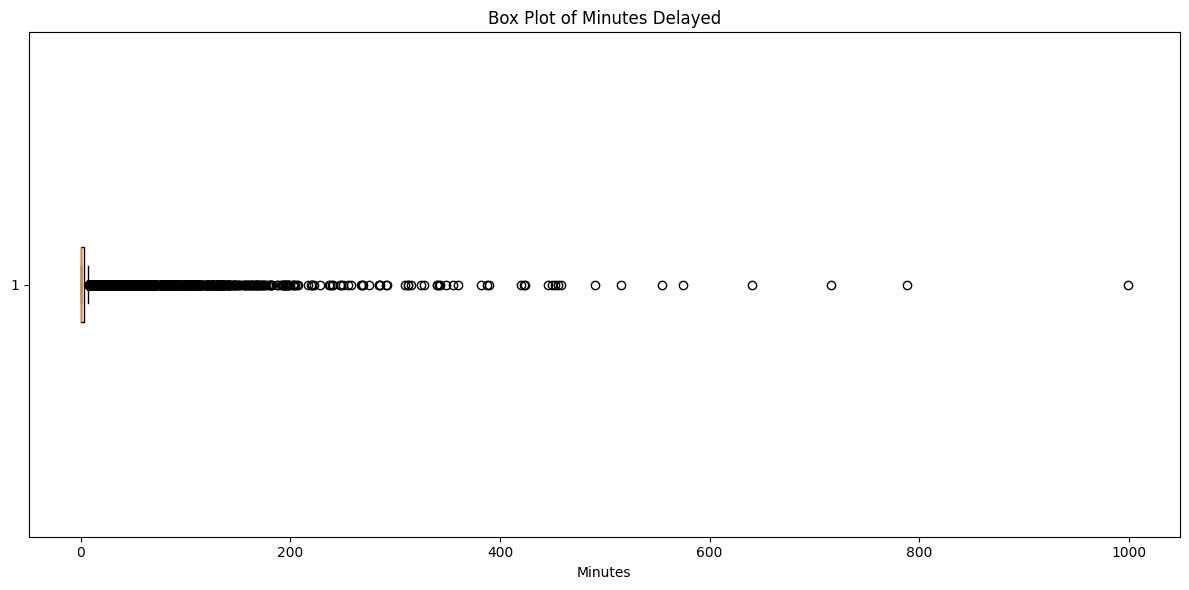

In [ ]:
plt.figure(figsize = (12, 6))
plt.boxplot(df_master['Min Delay'], vert = False)
plt.title('Box Plot of Minutes Delayed')
plt.xlabel('Minutes')
plt.tight_layout()
plt.show()

Looking at our box plot above, there seems to be instances wherein the minutes delayed lasted for more than 300 minutes, or 5 hours. Let's check if these instances make sense in the context of the cause of the delay.

In [ ]:
print(df_master[df_master['Min Delay'] > 300][['delay_cause', 'Min Delay']].sort_values(by = 'Min Delay'))
print("Total number of delay instances that lasted more than 300 minutes: ", df_master[df_master['Min Delay'] > 300]['delay_cause'].count())

                                         delay_cause  Min Delay
21578                                   VCC/RCIU/CCR        309
71212                            Miscellaneous Other        312
54336    Priority One - Train in Contact With Person        312
44166               Weather Reports / Related Delays        315
208211             Rail Defect/Fastenings/Power Rail        325
54985    Priority One - Train in Contact With Person        327
158739                                 Station Other        340
14165               Weather Reports / Related Delays        340
173047                                 Force Majeure        342
74265               Signals - Track Circuit Problems        343
69701                    Traction Power Rail Related        348
135428             Rail Defect/Fastenings/Power Rail        355
26967                 Fire/Smoke Plan B - Source TTC        360
53930                 Fire/Smoke Plan B - Source TTC        382
49265                           Rail Rel

Looking through the above table, we can determine that delays that lasted for 5 hours were caused by major incidents: train getting in contact with a person, criminal activity, fires, weather disturbances, structural defects, and voltage issues.

Although outliers can skew our data, we decide to keep these because we determined that the values are feasible given the nature of the cause of the delay.

# **DATASET**

---



In [ ]:
df_master

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,station_clean,line_clean,datetime,delay_cause,delay_category
0,2024-01-01,02:00,Monday,SHEPPARD STATION,MUI,0,0,N,YU,5491,Sheppard-Yonge,Lines 1 and 4 Shared,2024-01-01 02:00:00,Injured or ill Customer (On Train) - Transported,Passenger Related
1,2024-01-01,02:00,Monday,DUNDAS STATION,MUIS,0,0,N,YU,0,Dundas,Line 1 Yonge-University,2024-01-01 02:00:00,Injured or ill Customer (In Station) - Transpo...,Passenger Related
2,2024-01-01,02:08,Monday,DUNDAS STATION,MUPAA,4,10,N,YU,6051,Dundas,Line 1 Yonge-University,2024-01-01 02:08:00,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
3,2024-01-01,02:13,Monday,KENNEDY BD STATION,PUTDN,10,16,E,BD,5284,Kennedy,Lines 2 and 3 Shared,2024-01-01 02:13:00,Debris At Track Level - Uncontrollable,Fortuitous Event
4,2024-01-01,02:22,Monday,BLOOR STATION,MUPAA,4,10,N,YU,5986,Bloor-Yonge,Lines 1 and 2 Shared,2024-01-01 02:22:00,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215597,2017-04-30,19:50,Sunday,BLOOR DANFORTH SUBWAY,MUO,0,0,NaN,BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 19:50:00,Miscellaneous Other,Undefined
215598,2017-04-30,20:25,Sunday,WARDEN STATION,SUDP,4,8,W,BD,5107,Warden,Line 2 Bloor-Danforth,2017-04-30 20:25:00,Disorderly Patron,Passenger Related
215599,2017-04-30,20:29,Sunday,KEELE STATION,SUROB,0,0,NaN,BD,0,Keele,Line 2 Bloor-Danforth,2017-04-30 20:29:00,Robbery,Passenger Related
215600,2017-04-30,22:00,Sunday,YONGE UNIVERSITY LINE,MUO,0,0,NaN,YU/BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 22:00:00,Miscellaneous Other,Undefined
